In [1]:
!pip install wordcloud

  Obtaining dependency information for wordcloud from https://files.pythonhosted.org/packages/34/ac/72a4e42e76bf549dfd91791a6b10a9832f046c1d48b5e778be9ec012aa47/wordcloud-1.9.2-cp311-cp311-win_amd64.whl.metadata
   ---------------------------------------- 0.0/151.4 kB ? eta -:--:--
   ---------- ---------------------------- 41.0/151.4 kB 991.0 kB/s eta 0:00:01
   ----------------------------- ---------- 112.6/151.4 kB 2.2 MB/s eta 0:00:01
   ---------------------------------------- 151.4/151.4 kB 1.1 MB/s eta 0:00:00


In [1]:
import pandas as pd
import numpy as np
import math
import time
import random
import re
from PIL import Image
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

In [2]:
df = pd.read_csv('Corona_train.csv')
print(df)

          ID Sentiment                                        CoronaTweet
0      22979  Positive  I see all kinds of academics already whipping ...
1       9880  Negative  @HenrySmithUK can you raise with Boris please ...
2      35761  Negative  It s a confusing odd time for the shopping pub...
3      37968  Positive  Blog Summary: The Impact of COVID-19 on the Ca...
4      19709   Neutral  ??????? ??????? ???\r\r\nWaiting in a long Que...
...      ...       ...                                                ...
37859  20253   Neutral  DOUBLE TAP ??IF YOU REMEMBER BEING EMPLOYED?\r...
37860  38926  Positive  Struggling to understand why supermarkets or f...
37861  35889  Positive  For anyone interested in the checklist on cons...
37862  40641  Positive  Do you agree with the hypothesis that Indian s...
37863  26063   Neutral  In Richmond, local boutiques and thrift stores...

[37864 rows x 3 columns]


In [3]:
def vocabulary(x, mode):
    if mode==0:
        vocab = {}
        for tweet in x:
            for words in re.split('\r|\n|\s|\t|\!|\?|\.|\#|\,|\:', tweet.lower()):
                if(words != "" and words in vocab.keys()):
                    vocab.update({words:vocab[words]+1})
                elif(words != ""):
                    vocab[words] = 1
                else:
                    continue
    return vocab

vocab_pos = vocabulary(df.loc[df['Sentiment'] == 'Positive']['CoronaTweet'], 0)
vocab_neg = vocabulary(df.loc[df['Sentiment'] == 'Negative']['CoronaTweet'], 0)
vocab_neu = vocabulary(df.loc[df['Sentiment'] == 'Neutral']['CoronaTweet'], 0)
v = vocabulary(df['CoronaTweet'], 0)
print(vocab_pos)

{'i': 3924, 'see': 574, 'all': 2232, 'kinds': 8, 'of': 8803, 'academics': 2, 'already': 187, 'whipping': 1, 'up': 1568, 'some': 974, 'covid_19': 1242, 'related': 78, 'projects': 19, 'cfp': 1, 'syllabi': 1, 'articles': 14, 'and': 10774, 'blog': 68, 'posts': 12, 'iâ\x92m': 236, 'sittin': 1, 'over': 497, 'here': 759, 'browsing': 5, 'the': 18533, 'food': 2594, 'left': 133, '&amp;': 1657, 'tryin': 1, 'to': 17206, 'figure': 16, 'out': 1653, 'when': 984, 'go': 916, 'back': 366, 'grocery': 2743, 'store': 3009, 'apparently': 39, 'donâ\x92t': 285, 'do': 1071, 'well': 457, 'in': 7761, 'pandemic': 1291, 'summary': 10, 'impact': 319, 'covid-19': 3046, 'on': 3949, 'canadian': 30, 'residential': 7, 'housing': 56, 'market': 374, 'with': 2912, 'data': 212, 'from': 2228, '@local_logic': 1, 'https': 9610, '//t': 9617, 'co/yly8vyzh2r': 1, '--&gt;': 12, 'download': 37, 'full': 210, 'report': 174, 'co/y2pdlsteyr': 1, 'if': 1565, 'youâ\x92re': 84, 'running': 129, 'a': 8371, 'smallbusiness': 14, 'you': 4752, 

In [4]:
no_of_words = {}

for label in ['Positive', 'Negative', 'Neutral']:
    df_label = df.loc[df['Sentiment'] == label]['CoronaTweet']
    c = 0
    for tweet in df_label:
        lst = []
        lst = re.split('\r|\n|\s|\t|\!|\?|\.|\#|\,|\:', tweet)
        if '' in lst: lst.remove('')
        c += len(lst)
    no_of_words[label] = c
    
print(no_of_words)

{'Positive': 672108, 'Negative': 557966, 'Neutral': 222834}


In [5]:
def log_prob_priori(y):
    positive = math.log(y.loc[y == 'Positive'].shape[0]/y.shape[0])
    negative = math.log(y.loc[y == 'Negative'].shape[0]/y.shape[0])
    neutral = math.log(y.loc[y == 'Neutral'].shape[0]/y.shape[0])
    return [positive, negative, neutral]

def log_prob_posteriori(test_tweet, label, alpha, df):
    df_label = df.loc[df['Sentiment'] == label]
    vocab = {}
    if(label == 'Positive'):
        vocab = vocab_pos
    elif(label == 'Negative'):
        vocab = vocab_neg
    else:
        vocab = vocab_neu
    final_sum = 0
    for word in re.split('\r|\n|\s|\t|\!|\?|\.|\#|\,|\:', test_tweet):
        if(word != '' and word in vocab.keys()):
            sum_label = alpha + vocab[word]
        elif(word != ''):
            sum_label = alpha
        else:
            continue
        #final_sum += math.log(sum_label/(df_label.shape[0] + alpha*3))
        final_sum += math.log(sum_label/(no_of_words[label] + len(v)))
    return final_sum

def NaiveBayes(df, df_test, alpha):
    #df_test = pd.read_csv('Corona_validation.csv')
    labels = ['Positive', 'Negative', 'Neutral']
    predicted_label = list()
    log_priori = log_prob_priori(df['Sentiment'])
    prob_y = list()
    for tweet in df_test['CoronaTweet']:
        max_predict = list()
        for label in labels:
            max_predict.append(math.exp(log_prob_posteriori(tweet.lower(), label, alpha, df) + log_priori[labels.index(label)]))
        prob_y.append(max_predict)
        predicted_label.append(labels[max_predict.index(max(max_predict))])
    return prob_y, predicted_label

df_test = pd.read_csv('Corona_validation.csv')
prob_y_given_x_train, prediction_train = NaiveBayes(df, df, 1)
prob_y_given_x_validation, prediction_validation = NaiveBayes(df, df_test, 1)               

In [6]:
def accuracy(prediction, real):
    correct = 0
    for i in range(0, len(prediction)):
        if(prediction[i] == real[i]):
            correct += 1
    return correct/len(prediction)

acc_train = accuracy(prediction_train, df['Sentiment'].values.tolist())
acc_validation = accuracy(prediction_validation, df_test['Sentiment'].values.tolist())
print(acc_train, acc_validation)

0.8251901542362138 0.6975402368660796


In [8]:
!pip install --upgrade Pillow --user

In [9]:
pip install --upgrade pip

Note: you may need to restart the kernel to use updated packages.


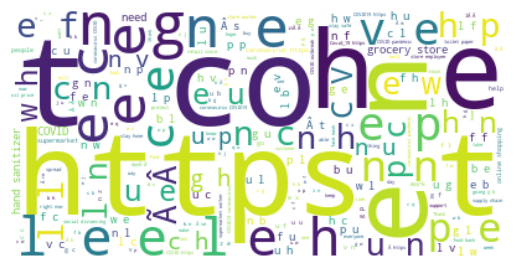

In [7]:
df_pos = df.loc[df['Sentiment'] == 'Positive']['CoronaTweet']
#df_neg = df.loc[df['Sentiment'] == 'Negative']['CoronaTweet']
#df_neu = df.loc[df['Sentiment'] == 'Neutral']['CoronaTweet']

file_pos = open('Positive_Tweets.txt', 'a', encoding="utf-8")
for tweet in df_pos:
    file_pos.write(tweet)
file_pos.close()

pos_tweet = open('Positive_Tweets.txt', 'r').read()
stopwords = set(STOPWORDS)
pos_wc = WordCloud(background_color='white', max_words=2000, stopwords=stopwords)
pos_wc.generate(pos_tweet)

plt.imshow(pos_wc, interpolation='bilinear')
plt.axis('off')
plt.show()

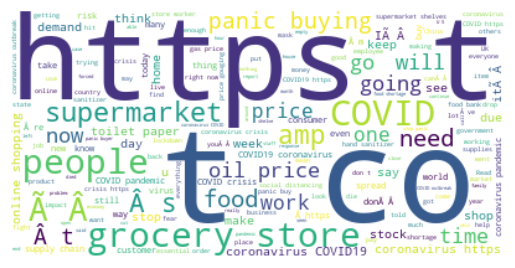

In [11]:
df_neg = df.loc[df['Sentiment'] == 'Negative']['CoronaTweet']

file_neg = open('Negative_Tweets.txt', 'a', encoding="utf-8")
for tweet in df_neg:
    file_neg.write(tweet)
file_neg.close()

neg_tweet = open('Negative_Tweets.txt', 'r').read()
stopwords = set(STOPWORDS)
neg_wc = WordCloud(background_color='white', max_words=2000, stopwords=stopwords)
neg_wc.generate(neg_tweet)

plt.imshow(neg_wc, interpolation='bilinear')
plt.axis('off')
plt.show()

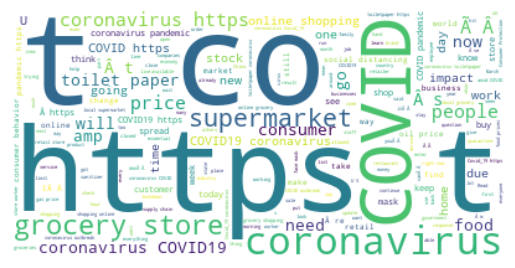

In [12]:
df_neu = df.loc[df['Sentiment'] == 'Neutral']['CoronaTweet']

file_neu = open('Neutral_Tweets.txt', 'a', encoding="utf-8")
for tweet in df_neu:
    file_neu.write(tweet)
file_neu.close()

neu_tweet = open('Neutral_Tweets.txt', 'r').read()
stopwords = set(STOPWORDS)
neu_wc = WordCloud(background_color='white', max_words=2000, stopwords=stopwords)
neu_wc.generate(neu_tweet)

plt.imshow(neu_wc, interpolation='bilinear')
plt.axis('off')
plt.show()

In [8]:
labels = ['Positive', 'Negative', 'Neutral']

prediction_random = list()
prediction_positive = list()
for i in range(0, len(prediction_validation)):
    prediction_random.append(random.choice(labels))
    prediction_positive.append('Positive')
    
acc_random = accuracy(prediction_random, df_test['Sentiment'].values.tolist())
acc_positive = accuracy(prediction_positive, df_test['Sentiment'].values.tolist())

print('Accuracy for random labelling : ', acc_random)
print('Accuracy for positive labelling : ', acc_positive)
print('Accuracy for Naive Bayes : ', acc_validation)

Accuracy for random labelling :  0.3291831156999696
Accuracy for positive labelling :  0.4385059216519891
Accuracy for Naive Bayes :  0.6975402368660796


In [9]:
#arr = np.dstack((np.array(prediction_validation), np.array(df_test['Sentiment'].values.tolist())))
real_validation = df_test['Sentiment'].values.tolist()

confusion_matrix = list()

pos = [0, 0, 0]
for i in range(0, len(prediction_validation)):
    if(real_validation[i] == 'Positive' and prediction_validation[i] == 'Positive'):
        pos[0] += 1
    elif(real_validation[i] == 'Positive' and prediction_validation[i] == 'Negative'):
        pos[1] += 1
    elif(real_validation[i] == 'Positive' and prediction_validation[i] == 'Neutral'):
        pos[2] += 1
confusion_matrix.append(pos)

neg = [0, 0, 0]
for i in range(0, len(prediction_validation)):
    if(real_validation[i] == 'Negative' and prediction_validation[i] == 'Positive'):
        neg[0] += 1
    elif(real_validation[i] == 'Negative' and prediction_validation[i] == 'Negative'):
        neg[1] += 1
    elif(real_validation[i] == 'Negative' and prediction_validation[i] == 'Neutral'):
        neg[2] += 1
confusion_matrix.append(neg)

neu = [0, 0, 0]
for i in range(0, len(prediction_validation)):
    if(real_validation[i] == 'Neutral' and prediction_validation[i] == 'Positive'):
        neu[0] += 1
    elif(real_validation[i] == 'Neutral' and prediction_validation[i] == 'Negative'):
        neu[1] += 1
    elif(real_validation[i] == 'Neutral' and prediction_validation[i] == 'Neutral'):
        neu[2] += 1
confusion_matrix.append(neu)

print(confusion_matrix)

[[1108, 270, 66], [204, 988, 40], [241, 175, 201]]


In [10]:
real_train = df['Sentiment'].values.tolist()

confusion_matrix_train = list()

pos = [0, 0, 0]
for i in range(0, len(prediction_train)):
    if(real_train[i] == 'Positive' and prediction_train[i] == 'Positive'):
        pos[0] += 1
    elif(real_train[i] == 'Positive' and prediction_train[i] == 'Negative'):
        pos[1] += 1
    elif(real_train[i] == 'Positive' and prediction_train[i] == 'Neutral'):
        pos[2] += 1
confusion_matrix_train.append(pos)

neg = [0, 0, 0]
for i in range(0, len(prediction_train)):
    if(real_train[i] == 'Negative' and prediction_train[i] == 'Positive'):
        neg[0] += 1
    elif(real_train[i] == 'Negative' and prediction_train[i] == 'Negative'):
        neg[1] += 1
    elif(real_train[i] == 'Negative' and prediction_train[i] == 'Neutral'):
        neg[2] += 1
confusion_matrix_train.append(neg)

neu = [0, 0, 0]
for i in range(0, len(prediction_train)):
    if(real_train[i] == 'Neutral' and prediction_train[i] == 'Positive'):
        neu[0] += 1
    elif(real_train[i] == 'Neutral' and prediction_train[i] == 'Negative'):
        neu[1] += 1
    elif(real_train[i] == 'Neutral' and prediction_train[i] == 'Neutral'):
        neu[2] += 1
confusion_matrix_train.append(neu)

print(confusion_matrix_train)

[[14971, 1477, 154], [1211, 12815, 140], [2010, 1627, 3459]]
